# Estimate time of introduction events

This notebook is for plotting parameter values and tree metrics taken from the posterior rather than the summary tree

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from io import StringIO
import time

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
print(pd.__version__)

0.24.2


## Grab all trees and process posterior

In [5]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [6]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [7]:
# trees file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.trees"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.trees"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.trees"}
skyline_human_off = {"label": "skyline-human-off", 
                     "trees": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts.trees"}

shuffled_months = {"label":"shuffled-months", 
                   "trees":"beast-runs/2021-12-21-mascot-3deme-skyline-shuffled-months/combined-2022-03-28.muts.trees"}

In [8]:
to_run = shuffled_months

trees_file_path = to_run['trees']
label = to_run['label']

burnin_percent = 0

In [9]:
all_trees = trees_file_path

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [10]:
"""given a parent node and its child, infer whether either the parent or child has a mutation on it"""

def mut_near_migration_event(parent, child):
    
    if 'mutations' in parent.traits:
        parent_mutation = parent.traits['mutations']
    else:
        parent_mutation = ""
        
    if 'mutations' in child.traits:
        child_mutation = child.traits['mutations']
        
    else:
        child_mutation = ""
        
    return(parent_mutation, child_mutation)

In [11]:
"""this function will iterate through the tree, and record each inferred migration event along the phylogeny. It
will also capture the inferred time of the migration event as a decimal date, and whether the parent or child branch
surrounding the migration event have any mutations on them. These values are stored in a dictionary where the 
key is a number to keep track of the total number of migratiton events on the tree, and the value is a dictionary
housing data about the migration event. this includes its type, the parent and child host states, date, and mutations"""

def enumerate_migration_events(tree):
        
    output_dict = {}
    migration_events_counter = 0
        
    for k in tree.Objects:
        trait = k.traits['typeTrait']
        parent_node = k.parent
        
        if 'typeTrait' not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits['typeTrait']
        
            if trait != parent_trait:
                migration_events_counter += 1

                migration_event = parent_trait + "-to-" + trait
                migration_date = parent_node.absoluteTime                

                # does a mutation occur on the parent or child branch? 
                parent_mut, child_mut = mut_near_migration_event(parent_node, k)

                # write to output dictionary
                output_dict[migration_events_counter] = {"type":migration_event, "date":migration_date,
                                                        "parent_host":parent_trait, "parent_mutations":parent_mut,
                                                        "child_host": trait, "child_mutations":child_mut}
    
    return(output_dict)

In [12]:
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    migrations_dict = {}
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            
            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                tree.setAbsoluteTime(2019.227)
                trees_processed += 1
                
                # iterate through the tree and pull out all migration events
                migrations_dict[tree_counter] = enumerate_migration_events(tree)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")

this took 253.14185500144958 seconds ( 4.219030916690826  minutes) to run on 2608 trees


In [13]:
"""this will generate a multi-index dataframe from the migrations dictionary"""

migrations_df = pd.DataFrame.from_dict({(i,j): migrations_dict[i][j] 
                           for i in migrations_dict.keys() 
                           for j in migrations_dict[i].keys()},
                       orient='index')

migrations_df.reset_index(inplace=True)
migrations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
migrations_df.head()

,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations
0,1,1,wild-to-domestic,1997.145087,wild,,domestic,
1,1,2,domestic-to-wild,1997.260926,domestic,,wild,
2,1,3,wild-to-domestic,2003.710760,wild,,domestic,
3,1,4,domestic-to-wild,2005.846676,domestic,,wild,
4,1,5,wild-to-domestic,2013.495770,wild,,domestic,


In [14]:
# print out any rows with NaNs
is_NaN = migrations_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = migrations_df[row_has_NaN]
rows_with_NaN

,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations


In [15]:
def convert_decimal_to_calendar_date_df(df):
    
    # call in R to convert collection date to decimal date and store as a new variable
    %R require(lubridate); library(lubridate); options(lubridate.fasttime = TRUE)
    %R -i df
    %R df1 <- df   # to have this properly return, you need to pass it a new dataframe name
    %R df1$date <- as.numeric(df1$date)
    %R df1$calendar_date = date_decimal(as.numeric(df1$date))
    %R -o df1
    
    df1['calendar_date'] = df1['calendar_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    return(df1)

In [16]:
# convert to calendar date
start_time = time.time()

migrations_df = convert_decimal_to_calendar_date_df(migrations_df)

print(time.time() - start_time)
migrations_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lubridate

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘lubridate’


  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:base’:

    date


  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:24: unexpected string constant
1: withVisible({df1<class 'datetime.date'
                           ^
50.00684595108032


,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations,calendar_date
0,1,1,wild-to-domestic,1997.145087,wild,,domestic,,1997-02-22
1,1,2,domestic-to-wild,1997.260926,domestic,,wild,,1997-04-05
2,1,3,wild-to-domestic,2003.710760,wild,,domestic,,2003-09-17
3,1,4,domestic-to-wild,2005.846676,domestic,,wild,,2005-11-05
4,1,5,wild-to-domestic,2013.495770,wild,,domestic,,2013-06-30


In [17]:
def separate_year(calendar_date):
    calendar_date = str(calendar_date)
    year = calendar_date.split("-")[0]
    return(year)

In [18]:
def separate_month(calendar_date):
    calendar_date = str(calendar_date)
    month = calendar_date.split("-")[1]    
    return(month)

In [19]:
# separate out month and year
migrations_df['year'] = migrations_df['calendar_date'].apply(separate_year)
migrations_df['month'] = migrations_df['calendar_date'].apply(separate_month)

migrations_df.head()

,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations,calendar_date,year,month
0,1,1,wild-to-domestic,1997.145087,wild,,domestic,,1997-02-22,1997,02
1,1,2,domestic-to-wild,1997.260926,domestic,,wild,,1997-04-05,1997,04
2,1,3,wild-to-domestic,2003.710760,wild,,domestic,,2003-09-17,2003,09
3,1,4,domestic-to-wild,2005.846676,domestic,,wild,,2005-11-05,2005,11
4,1,5,wild-to-domestic,2013.495770,wild,,domestic,,2013-06-30,2013,06


In [20]:
"""write to csv so I don't need to redo this every time!"""

path = to_run['trees'].replace(".trees",".trees.migrations-"+current_date+".tsv")
migrations_df.to_csv(path, sep="\t")

In [21]:
input_path = path
migrations_df = pd.read_csv(input_path, sep="\t")
migrations_df.head()

,Unnamed: 0,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations,calendar_date,year,month
0,0,1,1,wild-to-domestic,1997.145087,wild,NaN,domestic,NaN,1997-02-22,1997,2
1,1,1,2,domestic-to-wild,1997.260926,domestic,NaN,wild,NaN,1997-04-05,1997,4
2,2,1,3,wild-to-domestic,2003.710760,wild,NaN,domestic,NaN,2003-09-17,2003,9
3,3,1,4,domestic-to-wild,2005.846676,domestic,NaN,wild,NaN,2005-11-05,2005,11
4,4,1,5,wild-to-domestic,2013.495770,wild,NaN,domestic,NaN,2013-06-30,2013,6


In [22]:
print(len(migrations_df))
migrations_df['year'] = pd.to_numeric(migrations_df['year'])
#migrations_df = migrations_df[migrations_df['year'] > 2011]
print(len(migrations_df[migrations_df['year'] > 2011]))

779446
229810


In [23]:
def return_proportions_dataframe(input_df, time_unit):
    output_df = pd.DataFrame()
    
    for tree_number in set(input_df['tree_number'].tolist()):
        local_df1 = input_df[input_df['tree_number'] == tree_number]
        
        for v in list(set(input_df['type'].tolist())):
            local_df = local_df1[local_df1['type'] == v]
            total_transitions = len(local_df)

            for item in set(input_df[time_unit].tolist()):
                local_df2 = local_df[local_df[time_unit] == item]
                transitions_in_time_unit = len(local_df2)
                
                if total_transitions != 0:
                    prop_transitions_in_time_unit = transitions_in_time_unit/total_transitions
                else:
                    prop_transitions_in_time_unit = 0

                to_add = pd.DataFrame({"migration_direction":[v],time_unit:[item],"tree_number":[tree_number], 
                                       "total_transitions":[total_transitions],
                                       "transitions_in_time_interval":[transitions_in_time_unit],
                                      "proportion_transitions_in_time_interval":[prop_transitions_in_time_unit]})
                output_df = output_df.append(to_add)
            
    return(output_df)

In [24]:
def return_proportions_dataframe2(input_df, time_unit):
    output_df = pd.DataFrame()
    
    """first, subset a local dataframe for each type of host transition"""
    for t in list(set(input_df['type'].tolist())):
        local_df = input_df[input_df['type'] == t]
        total_transitions = len(local_df)
        
        """then, cut out all other columns except for the type of transition and the year and month"""
        local_df = local_df[[time_unit,'type']]
        local_df.set_index("type", inplace=True)
        
        """use value counts to get the number of times the particular time unit occurs in the local 
        subsetted dataframe"""
        x = pd.DataFrame(local_df[time_unit].value_counts())
        x.reset_index(inplace=True)
        x.columns = [time_unit,'transitions_in_time_interval']
        x['migration_direction'] = t
        x['proportion_transitions_in_time_interval'] = x['transitions_in_time_interval']/total_transitions
        
        output_df = output_df.append(x)
            
    return(output_df)

In [25]:
def return_proportions_dataframe3(input_df, time_unit):
    output_df = pd.DataFrame()
    
    """first, subset the input dataframe by type of transition"""
    for t in list(set(input_df['type'].tolist())):
        local_df = input_df[input_df['type'] == t]
        total_transitions = len(local_df)
        
        """next, subset by month"""
        for time in set(input_df[time_unit].tolist()):
            local_df1 = local_df[local_df[time_unit] == time]
            
            counts_df = pd.DataFrame(local_df1['tree_number'].value_counts())
            counts_df.reset_index(inplace=True)
            counts_df.columns = ['counts','tree_number']
            counts_df[time_unit] = time
            counts_df['migration_direction'] = t
                
            output_df = output_df.append(counts_df)
            
    return(output_df, counts_df)

In [26]:
start_time = time.time()

mig = return_proportions_dataframe(migrations_df, "month")

total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print(total_time_minutes)

mig.head()

9.331095989545187


,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval
0,wild-to-domestic,1,1,162,16,0.098765
0,wild-to-domestic,2,1,162,14,0.086420
0,wild-to-domestic,3,1,162,9,0.055556
0,wild-to-domestic,4,1,162,7,0.043210
0,wild-to-domestic,5,1,162,8,0.049383


In [27]:
mig.head()

,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval
0,wild-to-domestic,1,1,162,16,0.098765
0,wild-to-domestic,2,1,162,14,0.086420
0,wild-to-domestic,3,1,162,9,0.055556
0,wild-to-domestic,4,1,162,7,0.043210
0,wild-to-domestic,5,1,162,8,0.049383


In [28]:
# write out to tsv
mig_path = to_run['trees'].replace(".trees",".trees.prop-migrations-per-month-"+current_date+".tsv")
mig.to_csv(mig_path, sep="\t")

In [10]:
mig = pd.read_csv(mig_path, sep="\t")
mig.head()

,Unnamed: 0,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval
0,0,wild-to-human,1,1,1,0,0.0
1,0,wild-to-human,2,1,1,0,0.0
2,0,wild-to-human,3,1,1,1,1.0
3,0,wild-to-human,4,1,1,0,0.0
4,0,wild-to-human,5,1,1,0,0.0


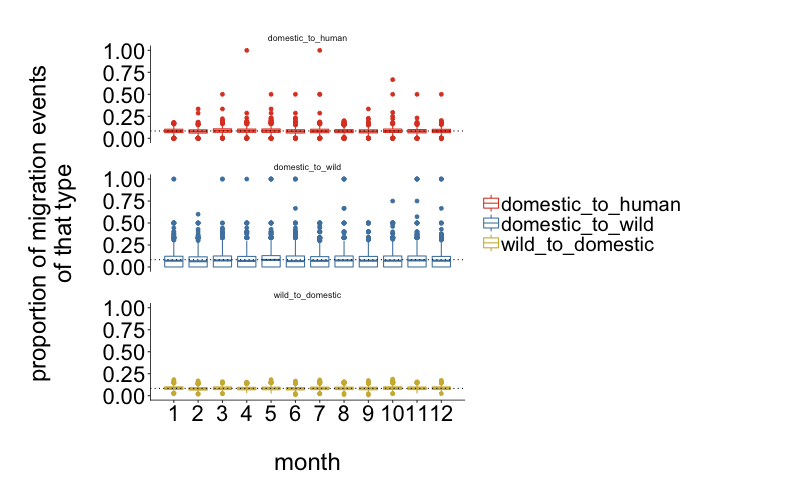

In [73]:
%%R -w 800 -h 500 -u px -i mig,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("mig-times-month-boxplot-",label,"-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[!(mig$migration_direction=="wild_to_human"),]

p <- ggplot(data=mig, aes(x=month, y=proportion_transitions_in_time_interval, color=migration_direction,group=month)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_boxplot(position="dodge")+
    geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~migration_direction, ncol=1)+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(domestic_to_human=human_color,wild_to_domestic=wild_color,domestic_to_wild=domestic_color,wild_to_human="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 12, device = "pdf", path = "figures", dpi = 300)
p

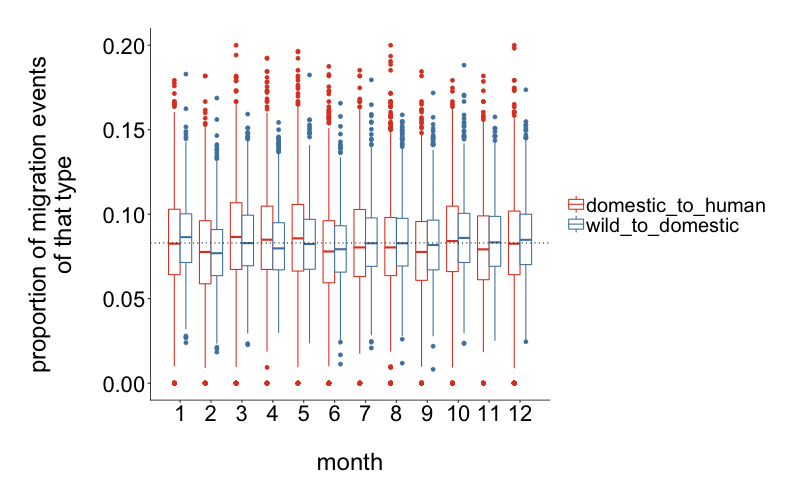

In [75]:
%%R -w 800 -h 500 -u px -i mig,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("mig-times-month-boxplot-dodged-",label,"-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[!(mig$migration_direction=="wild_to_human"),]
mig <- mig[!(mig$migration_direction=="domestic_to_wild"),]

p <- ggplot(data=mig, aes(x=month, y=proportion_transitions_in_time_interval, color=migration_direction,group=interaction(month,migration_direction))) + 
    #geom_point(size=1, alpha=0.6)+
    geom_boxplot(position="dodge")+
    geom_hline(yintercept=0.083, linetype=3)+
    #facet_wrap(~migration_direction, ncol=1, scales="free_y")+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(domestic_to_human=human_color,wild_to_domestic=domestic_color,domestic_to_wild=domestic_color,wild_to_human="grey50"))+
    scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 15, height = 5, device = "pdf", path = "figures", dpi = 300)
p

In [11]:
mig.head()

,Unnamed: 0,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval
0,0,wild-to-human,1,1,1,0,0.0
1,0,wild-to-human,2,1,1,0,0.0
2,0,wild-to-human,3,1,1,1,1.0
3,0,wild-to-human,4,1,1,0,0.0
4,0,wild-to-human,5,1,1,0,0.0


In [22]:
# make a summary table with the mean per month per direction, with confidence intervals 
import pymc3
summary_table = pd.DataFrame()

for migration_direction in set(mig['migration_direction'].tolist()):
    for month in set(mig['month'].tolist()):
        local_df = mig[(mig["migration_direction"]==migration_direction) & (mig["month"]==month)]

        mean = local_df['proportion_transitions_in_time_interval'].mean()
        hpd = pymc3.stats.hpd(local_df['proportion_transitions_in_time_interval'], 0.95)
        lower_hpd = hpd[0]
        upper_hpd = hpd[1]
        
        new_df = pd.DataFrame.from_dict({"migration_direction":migration_direction, "month":month,
                                        "mean":mean, "lower_hpd":[lower_hpd], "upper_hpd": [upper_hpd]})
        
        summary_table = summary_table.append(new_df)
        
summary_table.head()

,migration_direction,month,mean,lower_hpd,upper_hpd
0,wild-to-human,1,0.055389,0.0,0.500000
0,wild-to-human,2,0.035411,0.0,0.250000
0,wild-to-human,3,0.044004,0.0,0.333333
0,wild-to-human,4,0.031911,0.0,0.250000
0,wild-to-human,5,0.030786,0.0,0.250000


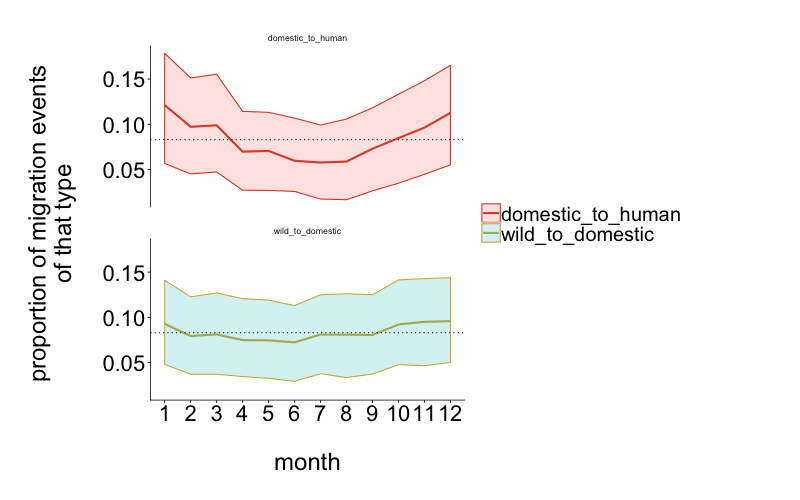

In [52]:
%%R -w 800 -h 500 -u px -i summary_table,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("mig-times-month-lineplot-",label,"-",current_date,".pdf", sep="")

summary_table$migration_direction = gsub("-","_",summary_table$migration_direction)
summary_table$month = as.numeric(summary_table$month)

# optionally, remove wild to human
summary_table <- summary_table[!(summary_table$migration_direction=="wild_to_human"),]
summary_table <- summary_table[!(summary_table$migration_direction=="domestic_to_wild"),]

p <- ggplot(data=summary_table, aes(x=month, y=mean, color=migration_direction, fill=migration_direction)) + 
    geom_line(size=1)+
    geom_ribbon(data=summary_table, aes(y=mean, ymin=lower_hpd, ymax=upper_hpd), alpha=0.2)+
    geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~migration_direction, ncol=1)+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(domestic_to_human=human_color,wild_to_domestic=wild_color,domestic_to_wild=domestic_color,wild_to_human="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 8, device = "pdf", path = "figures", dpi = 300)
p

In [38]:
%%R -w 800 -h 500 -u px -i mig,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("mig-times-year-",label,"-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)

# optionally, remove wild to human
mig <- mig[!(mig$migration_direction=="wild_to_human"),]

p <- ggplot(data=mig, aes(x=year, y=proportion_transitions_in_time_interval, color=migration_direction,group=migration_direction)) + 
    geom_point(size=3, alpha=0.8)+
    geom_hline(yintercept=0.083, linetype=3)+
    #geom_line(stat="count")+
    labs(x="\nyear", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(domestic_to_human=human_color,wild_to_domestic=wild_color,domestic_to_wild=domestic_color,wild_to_human="grey50"))+
    scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(1996,2019,5), limits=c(1996,2019))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=16, colour="black", hjust=0.5,))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 14, height = 6, device = "pdf", path = "figures", dpi = 300)
p


Error: Column `x` must be a 1d atomic vector or a list
Call `rlang::last_error()` to see a backtrace


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Don't know how to automatically pick scale for object of type function. Defaulting to continuous.

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: Column `x` must be a 1d atomic vector or a list
Call `rlang::last_error()` to see a backtrace

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: `panel.margin` is deprecated.

## Plot genomes by collection month

As a check on this, I'm going to plot the distribution of genomes for each group by their month of collection

In [21]:
alignment = "alignments/aligned_h5n1_ha-3deme-1per-country-month-host-downsampled-bad-dates-2021-06-09-with-annotations-2021-06-09.fasta"

In [22]:
def return_date_resolution(date):
    date = date.replace("-XX","")
    
    if len(date) == 4:
        date_resolution = "year"
    elif len(date) == 7:
        date_resolution = "month"
    elif len(date) == 10:
        date_resolution = "day"
    else:
        print("what's up with this date ", date)
    
    return(date_resolution)

In [23]:
import Bio 
from Bio import SeqIO

sequences_month_dict = {"human":[], "domestic":[], "wild":[]}
date_resolution_dict = {"human":{}, "domestic":{}, "wild":{}}

for seq in SeqIO.parse(alignment, "fasta"):
    date = seq.description.split("|")[2]
    year = date.split("-")[0]
    month = date.split("-")[1]
    day = date.split("-")[2]
    host_group = seq.description.split("|")[9]
    resolution = return_date_resolution(date)
    
    if host_group == '':
        print(seq.description)
    
    sequences_month_dict[host_group].append(month)
    
    if year not in date_resolution_dict[host_group]:
        date_resolution_dict[host_group][year] = {}
    
    if resolution not in date_resolution_dict[host_group][year]:
        date_resolution_dict[host_group][year][resolution] = 1
    else: 
        date_resolution_dict[host_group][year][resolution] += 1

In [24]:
seqs_month_df = pd.DataFrame()

for host in sequences_month_dict:
    total_seqs = len(sequences_month_dict[host])
    
    for i in ['01','02','03','04','05','06','07','08','09','10','11','12','XX']:
        month = i
        month_count = sequences_month_dict[host].count(month)
        
        local_df = pd.DataFrame({'host':[host], 'total_seqs':total_seqs, 'month':month, 
                                 'seqs_in_month':month_count, 'proportion_in_month':month_count/total_seqs})
        
        seqs_month_df = seqs_month_df.append(local_df)

In [25]:
seqs_month_df.head()

,host,total_seqs,month,seqs_in_month,proportion_in_month
0,human,125,01,16,0.128
0,human,125,02,16,0.128
0,human,125,03,15,0.120
0,human,125,04,13,0.104
0,human,125,05,7,0.056


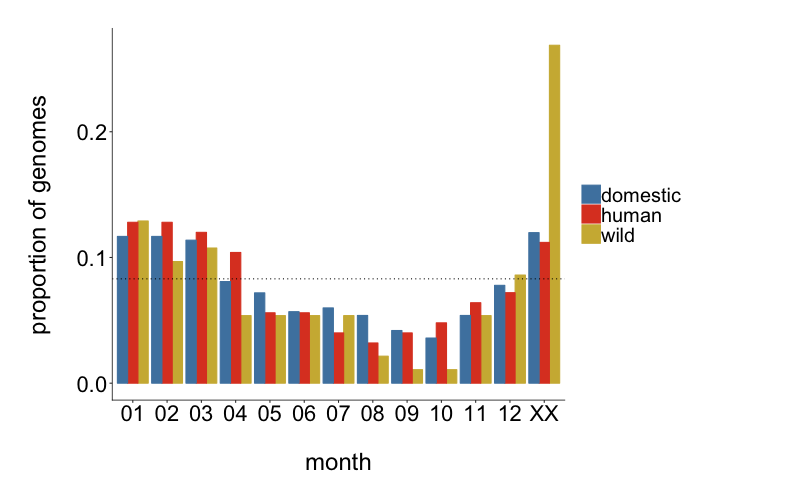

In [27]:
%%R -w 800 -h 500 -u px -i seqs_month_df,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("genomes-per-month-",current_date,".pdf", sep="")

#seqs_month_df$month = as.numeric(seqs_month_df$month)

p <- ggplot(data=seqs_month_df, aes(x=month, y=proportion_in_month, color=host, fill=host)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_col(position="dodge")+
    geom_hline(yintercept=0.083, linetype=3)+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of genomes\n")+
    scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
    scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
   # scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [28]:
date_resolution_dict

{'human': {'2001': {'year': 1},
  '1998': {'year': 1},
  '1997': {'year': 1},
  '2007': {'day': 12, 'year': 1},
  '2013': {'day': 10},
  '2012': {'day': 8},
  '2014': {'day': 5},
  '2010': {'day': 10},
  '2011': {'day': 12, 'year': 1},
  '2009': {'day': 6, 'year': 1},
  '2008': {'day': 12, 'month': 1, 'year': 1},
  '2004': {'day': 3, 'year': 1},
  '2003': {'day': 1, 'year': 1},
  '2005': {'day': 10, 'year': 2},
  '2006': {'day': 18, 'year': 3},
  '2015': {'day': 2},
  '2019': {'day': 1}},
 'domestic': {'1996': {'year': 1},
  '2004': {'year': 3, 'day': 4},
  '2001': {'year': 1},
  '2002': {'year': 1},
  '2000': {'year': 1},
  '1997': {'year': 1},
  '1999': {'year': 1},
  '2007': {'day': 21, 'year': 6, 'month': 7},
  '2013': {'day': 22, 'year': 1},
  '2012': {'day': 31},
  '2011': {'day': 21, 'month': 7},
  '2010': {'day': 17, 'year': 3, 'month': 10},
  '2009': {'day': 13, 'month': 4, 'year': 2},
  '2006': {'day': 24, 'year': 7, 'month': 4},
  '2003': {'year': 3, 'day': 3},
  '2005': {'d

In [15]:
date_resolution_df = pd.DataFrame.from_dict(date_resolution_dict, orient="columns")
date_resolution_df = date_resolution_df.fillna(0)
date_resolution_df.reset_index(inplace=True)
date_resolution_df

,index,human,domestic,wild
0,1997,{'year': 1},{'year': 1},0
1,1998,{'year': 1},0,0
2,1999,0,{'year': 1},0
3,2000,0,{'year': 1},0
4,2001,0,{'year': 2},0
5,2002,0,{'year': 1},0
6,2003,0,"{'year': 1, 'day': 2}",{'day': 2}
7,2004,"{'day': 4, 'year': 1}","{'day': 4, 'year': 1}","{'year': 4, 'day': 1}"
8,2005,"{'day': 6, 'year': 2}","{'day': 2, 'year': 5}","{'year': 1, 'day': 3}"
9,2006,"{'day': 11, 'year': 1}","{'year': 5, 'month': 1, 'day': 24}","{'day': 10, 'year': 2}"


In [23]:
date_resolution_df_melt = date_resolution_df.melt(id_vars=['index'])
date_resolution_df_melt.head()

,index,variable,value
0,1996,human,0
1,1997,human,{'year': 2}
2,1998,human,{'year': 1}
3,1999,human,0
4,2000,human,0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "value". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'dict'>'
  (name, str(e)))


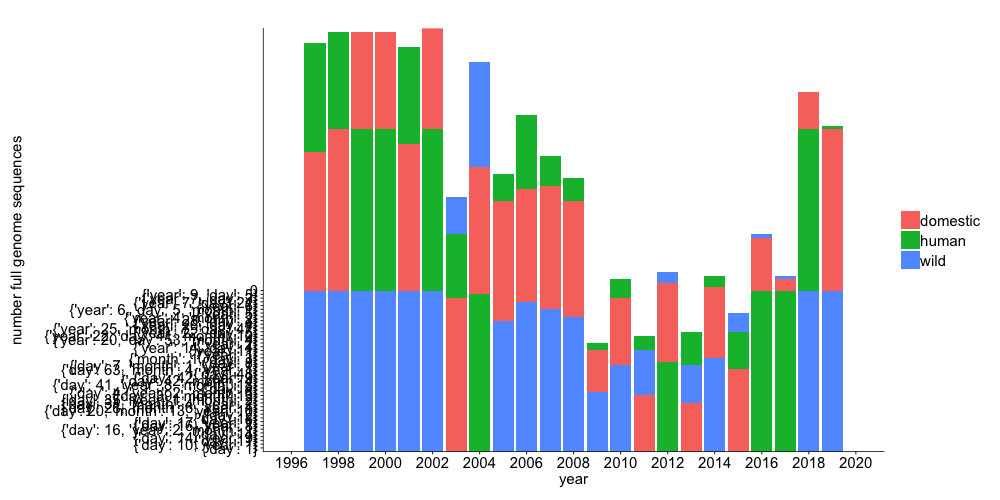

In [24]:
%%R -w 1000 -h 500 -u px -i date_resolution_df_melt  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

date_resolution_df_melt$index = as.numeric(date_resolution_df_melt$index)

p <- ggplot(data=date_resolution_df_melt, aes(x=index, y=value, fill=variable)) + 
    geom_col()+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #scale_colour_manual(values=c("#4C9C86","#271B9C"), guide=FALSE)+
    #scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

#ggsave("aligned-seqs-per-year-date-resolution-2021-05-21.pdf", p, width = 12, height = 5, path=output_directory)
p